In [150]:
#  bibliothèques
import os              # Gestion des fichiers et chemins
import pandas as pd    # Manipulation des données tabulaires
import matplotlib.pyplot as plt  # Visualisation
import cv2             # Traitement d’images
import numpy as np     # Calculs numériques
from sklearn.model_selection import train_test_split  # Séparation données


In [151]:
#  Définition des chemins vers les données

data_path = '../data/raw'  # Dossier contenant les datasets
labels_path = os.path.join(data_path, 'cleaned_data.csv')  # CSV nettoyé
images_dir = os.path.join(data_path, 'images') # Dossier des images


In [152]:
# Chargement et nettoyage des labels
df = pd.read_csv(labels_path)
df.columns = df.columns.str.strip()   # Nettoyer les espaces invisibles
df = df[['Image Index', 'Finding Labels', 'Patient Age', 'Patient Gender']]


In [153]:
# Liste des pathologies
pathologies = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
               'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
               'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


In [154]:
# Transformation en colonnes binaires
for p in pathologies:
    if p not in df.columns:
        df[p] = df['Finding Labels'].apply(lambda x: 1 if p in x else 0)

# Vérification des pathologies
print("\nComptage des pathologies :")
print(df[pathologies].sum())



Comptage des pathologies :
Atelectasis           11559
Cardiomegaly           2776
Effusion              13317
Infiltration          19894
Mass                   5782
Nodule                 6331
Pneumonia              1431
Pneumothorax           5302
Consolidation          4667
Edema                  2303
Emphysema              2516
Fibrosis               1686
Pleural_Thickening     3385
Hernia                  227
dtype: int64


In [155]:
# Statistiques patients
print("\nÂge moyen des patients :", df['Patient Age'].mean())
print("\nRépartition par genre :")
print(df['Patient Gender'].value_counts())


Âge moyen des patients : 46.90146271851587

Répartition par genre :
Patient Gender
M    63340
F    48780
Name: count, dtype: int64


In [156]:
# Fonction pour charger et normaliser une image
def load_image(img_name, size=(224,224)):
    path = os.path.join(images_dir, img_name)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f" Image non trouvée : {img_name}")
        return None
    img = cv2.resize(img, size)
    img = img / 255.0
    return img

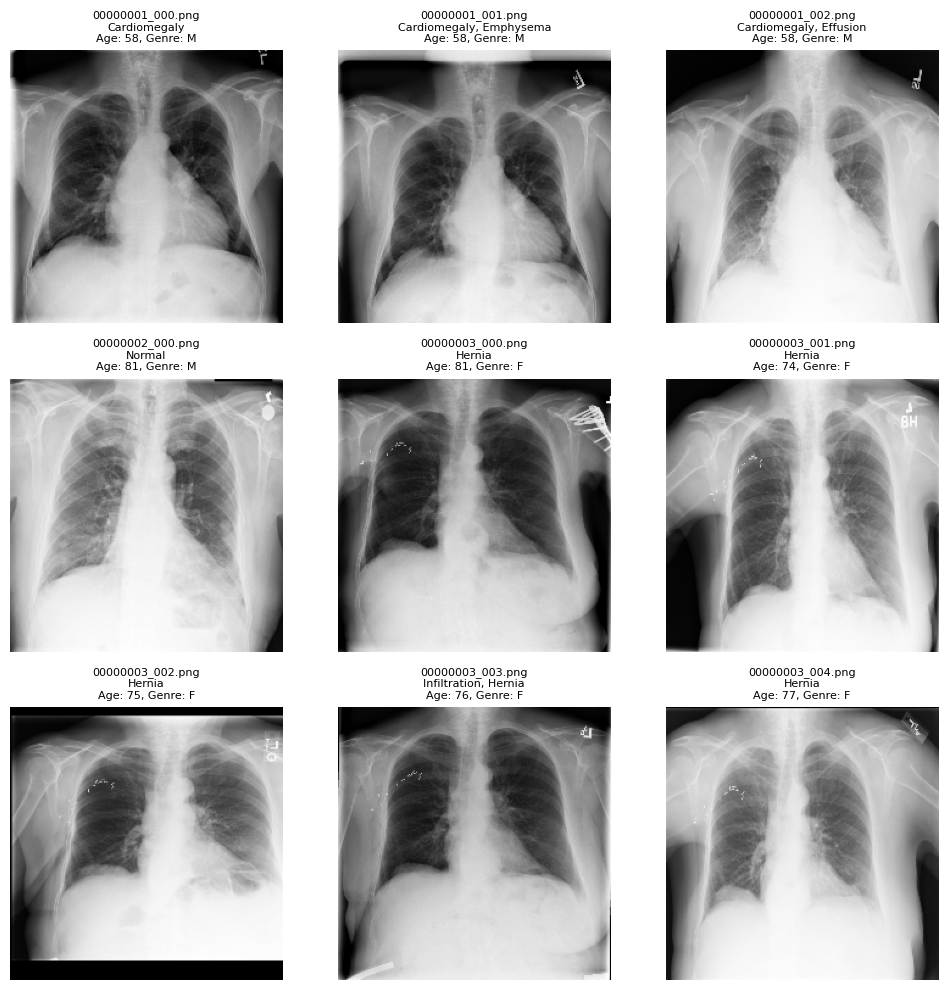

In [157]:
# Visualisation de  images d'exemple
sample_images = df['Image Index'].head(9).tolist()
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax, img_name in zip(axes.flatten(), sample_images):
    img = load_image(img_name)
    if img is not None:
        row = df[df['Image Index']==img_name].iloc[0]
        labels = [p for p in pathologies if row[p]==1]
        titre = f"{row['Image Index']}\n" + (", ".join(labels) if labels else "Normal") + \
                f"\nAge: {row['Patient Age']}, Genre: {row['Patient Gender']}"
        ax.set_title(titre, fontsize=8)
        ax.imshow(img, cmap='gray')
    else:
        ax.set_title("Erreur de chargement", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [158]:
# Chargement complet pour modèle IA
max_images = 5000  # Limite pour l'exemple, ajustable
X_list, y_list, valid_images = [], [], []

for img_name in df['Image Index'].head(max_images):
    img = load_image(img_name)
    if img is not None:
        X_list.append(img[..., np.newaxis])  # Ajouter dimension channel
        y_list.append(df[df['Image Index']==img_name][pathologies].values[0])
        valid_images.append(img_name)

print(f" Nombre d'images valides : {len(valid_images)}")

# Conversion en tableaux NumPy
X = np.array(X_list)
y = np.array(y_list)
print(f"Taille des données : X = {X.shape} , y = {y.shape}")


 Image non trouvée : 00001336_000.png
 Nombre d'images valides : 4999
Taille des données : X = (4999, 224, 224, 1) , y = (4999, 14)


In [159]:
# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape[0]} images, Test: {X_test.shape[0]} images")


Train: 3999 images, Test: 1000 images


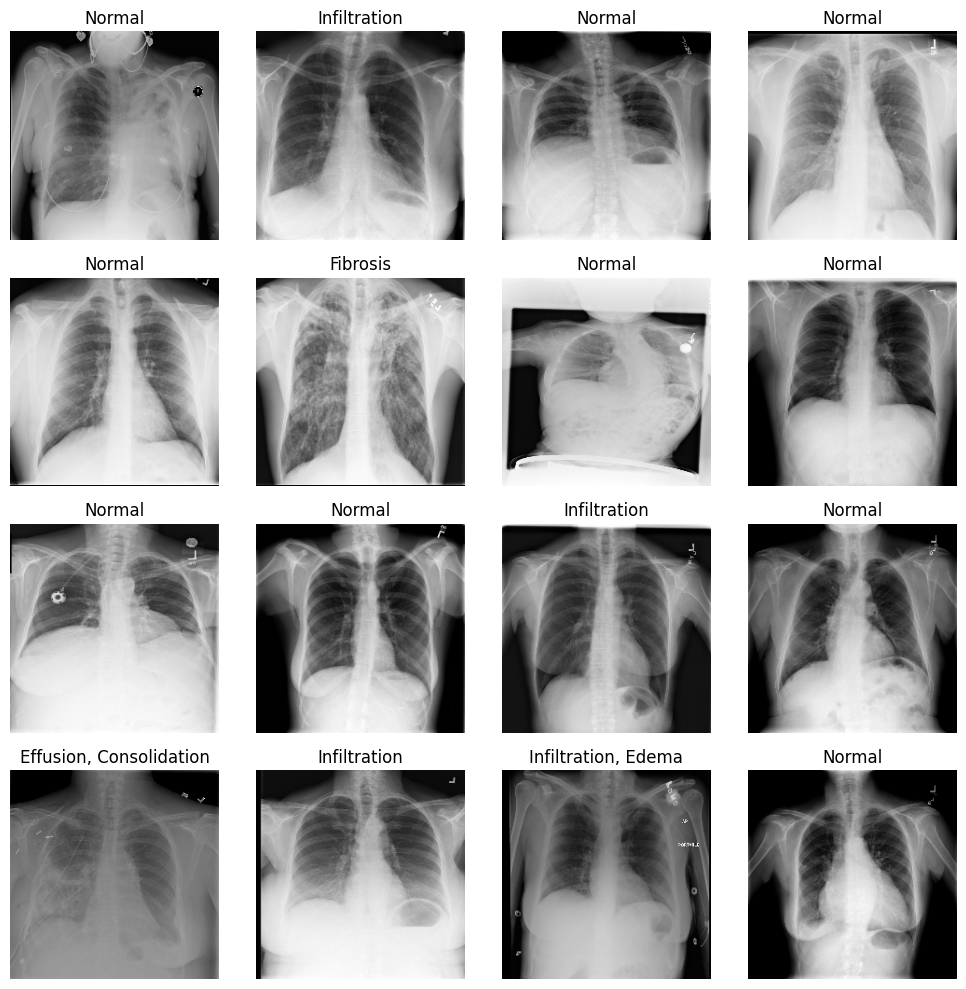

In [160]:
# Vérification rapide(test)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i,:,:,0], cmap='gray')
    labels = [p for p, val in zip(pathologies, y_train[i]) if val==1]
    plt.title(", ".join(labels) if labels else "Normal")
    plt.axis('off')
plt.tight_layout()
plt.show()